In [1]:
import numpy as np
import pandas as pd
import pickle
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm,gaussian_kde,spearmanr

In [8]:
cols = ['Distance_from_hole','Cat','Par_Value','Year','Course_#','Round','Player_#','Strokes_Gained']

In [9]:
data = pd.concat([pd.read_csv('./../data/%d.csv' % year)[cols] for year in range(2003,2017)])

In [10]:
rdata = pd.read_csv('./../data/round.csv')

In [11]:
rdata.head(2)

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694


In [12]:
data.head(2)

,Distance_from_hole,Cat,Par_Value,Year,Course_#,Round,Player_#,Strokes_Gained
0,1138.807687,Tee Box,4,2003,37,1,1006,0.229988
1,463.466797,Fairway,4,2003,37,1,1006,-0.596317


In [13]:
with open('./../PickleFiles/hole_tups.pkl','r') as pickleFile:
    tournorder = pickle.load(pickleFile)

In [14]:
df = pd.DataFrame(tournorder)
df.columns = ['Year','Permanent_Tournament_#','Round','Course_#','Hole']
round_tups = df[['Year','Course_#','Round']].drop_duplicates().values.tolist()
round_tups = [tuple(tup) for tup in round_tups]

In [15]:
round_tups[0:5]

[(2003, 656, 1), (2003, 656, 2), (2003, 656, 3), (2003, 656, 4), (2003, 6, 2)]

In [16]:
def make_specific_cats(distance,cat,par):
    if cat=='Tee Box':
        if par==3:
            return 'Tee-3'
        else:
            return 'Tee-45'
    elif cat=='Bunker' or cat=='Other':
        return cat
    elif cat=='Green' or cat=='Fringe':
        if distance<5:
            return 'Green-0'
        elif distance<10:
            return 'Green-5'
        elif distance<20:
            return 'Green-10'
        else:
            return 'Green-20'
    elif cat=='Fairway':
        if distance<300:
            return 'Fairway-0'
        elif distance<540:
            return 'Fairway-300'
        else:
            return 'Fairway-540'
    elif cat=='Primary Rough' or cat=='Intermediate Rough':
        if distance<90:
            return 'Rough-0'
        elif distance<375:
            return 'Rough-90'
        else:
            return 'Rough-375'

In [17]:
data.insert(len(data.columns),'Specific_Cat',
            [make_specific_cats(tup[0],tup[1],tup[2]) 
             for tup in data[['Distance_from_hole','Cat','Par_Value']].values.tolist()])

In [18]:
data.Specific_Cat.value_counts()

Green-0        2818013
Tee-45         2781546
Green-20       1358330
Fairway-300    1145044
Green-10       1035734
Green-5         874724
Tee-3           823746
Rough-375       695727
Fairway-540     641033
Fairway-0       602925
Bunker          503585
Rough-0         480052
Rough-90        262059
Other            68023
Name: Specific_Cat, dtype: int64

First a baseline of SG to field using simple average SG on different categories of shots.

In [32]:
course_profiles = defaultdict(lambda: defaultdict(list))
for year,course,round in round_tups:
    day = data[(data.Year==year) & (data['Course_#']==course) & (data.Round==round)]
    cat_aves = {}
    for cat,df in day.groupby('Specific_Cat'):
        player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
        cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 
                                  for player in pd.unique(day['Player_#'])])
    rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
    if len(rday)==0:
        continue
    ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
    score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
    score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan 
                          for player in pd.unique(day['Player_#'])])
    for cat in cat_aves:
        cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
        course_profiles[course][cat].append(spearmanr(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0])

In [33]:
for cat in pd.unique(data.Specific_Cat):
    print '**** %s ****' % cat
    for course in course_profiles:
        print course,len(course_profiles[course][cat]),np.mean(course_profiles[course][cat])

**** Tee-45 ****
512 11 -0.230752248452
513 56 -0.253414769015
770 28 -0.28880289158
643 4 -0.334592513309
4 55 -0.266339320431
5 53 -0.216517392598
6 56 -0.256993633132
775 16 -0.271425557363
8 56 -0.273284888665
649 46 -0.150662436389
11 56 -0.229226119339
12 56 -0.201410634031
13 20 -0.257250251817
526 32 -0.290826381319
527 4 -0.268834270893
656 55 -0.18501882861
19 53 -0.229495438281
660 36 -0.285981678541
21 56 -0.244640078118
534 4 -0.325185121625
23 56 -0.235648447373
24 31 -0.284327214606
665 56 -0.224029034035
538 53 -0.277545178761
27 20 -0.263711294319
669 56 -0.278811697652
773 8 -0.332625825749
32 24 -0.274781673379
35 28 -0.302892623048
36 56 -0.383489707046
37 12 -0.39903699572
689 8 -0.314672595205
552 8 -0.310962810776
772 4 -0.283893873879
45 40 -0.273125504565
687 4 -0.319592449993
688 48 -0.262272120481
776 24 -0.210697681833
819 8 -0.280422993299
692 4 -0.181383511744
694 12 -0.331170569227
9 56 -0.265421687718
696 16 -0.24890280281
185 3 -0.0637528955582
698 56 -

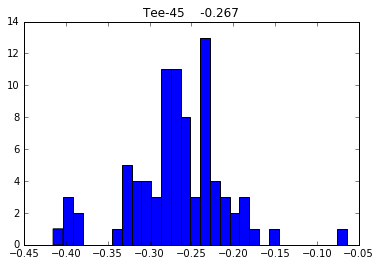

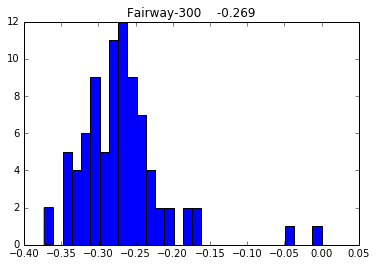

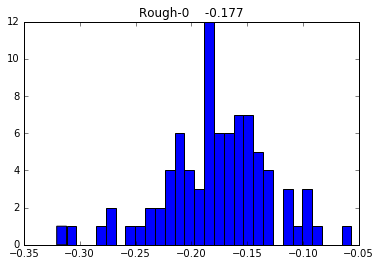

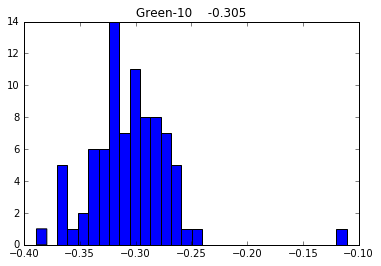

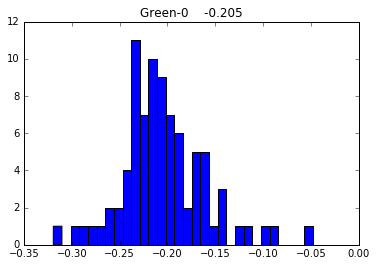

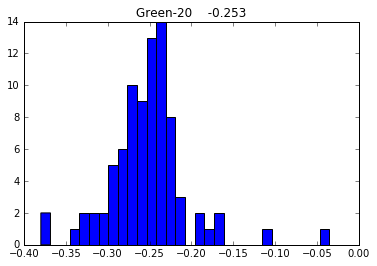

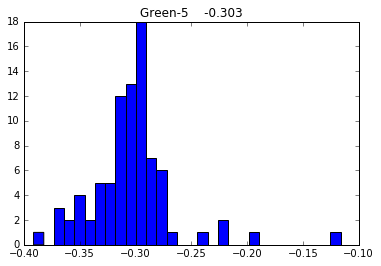

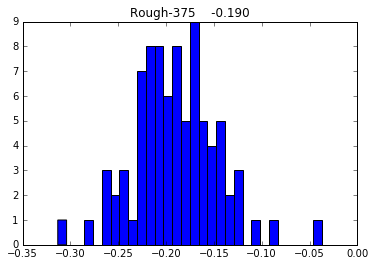

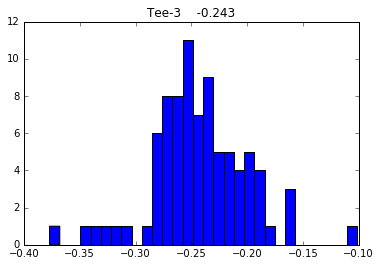

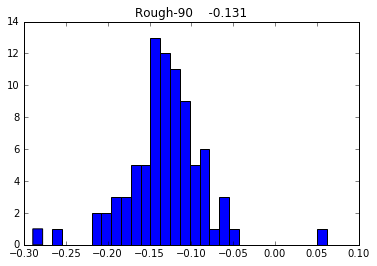

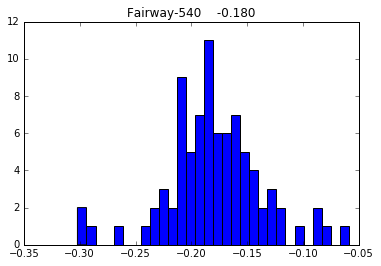

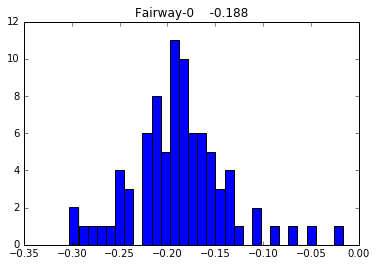

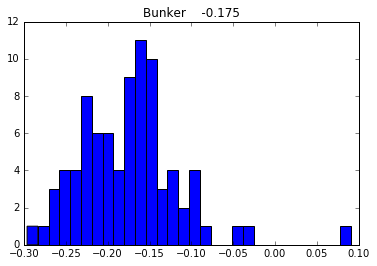

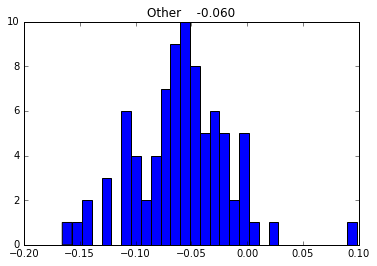

In [34]:
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    plt.hist(x,bins=30)
    plt.title(cat+'    %.3f' % np.mean(x))
    plt.show()

Set Priors

In [35]:
priors = defaultdict(None)
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    priors[cat] = (np.mean(x),np.std(x))

In [36]:
priors

defaultdict(None,
            {'Bunker': (-0.1752483104451765, 0.059529193445688681),
             'Fairway-0': (-0.18752762501539536, 0.049919933242929038),
             'Fairway-300': (-0.26948754784591328, 0.057925622409077122),
             'Fairway-540': (-0.179750648641954, 0.043486264717265029),
             'Green-0': (-0.20477498715182232, 0.044626936936104152),
             'Green-10': (-0.30511469837012345, 0.036170261435159487),
             'Green-20': (-0.25252973232861581, 0.047741004909088114),
             'Green-5': (-0.30322402699983675, 0.037828476466139231),
             'Other': (-0.059671034861664154, 0.042262513080836381),
             'Rough-0': (-0.17724790950990965, 0.047651620755406972),
             'Rough-375': (-0.19022227504794906, 0.043510139800904173),
             'Rough-90': (-0.13149026689402177, 0.046372594959776713),
             'Tee-3': (-0.24304553222181047, 0.042586811617530959),
             'Tee-45': (-0.26687821894186542, 0.0570854332002124

In [37]:
for cat in pd.unique(data.Specific_Cat):
    mean,std = priors[cat][0],priors[cat][1]
    priors[cat] = [np.linspace(mean-3*std,mean+3*std,100),
                   norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std)/
                    norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std).sum()]

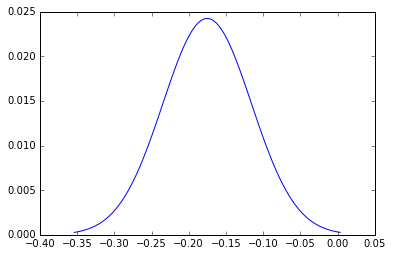

In [38]:
plt.plot(priors['Bunker'][0],priors['Bunker'][1]);

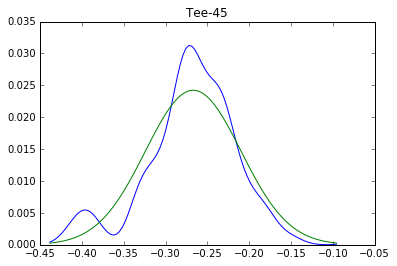

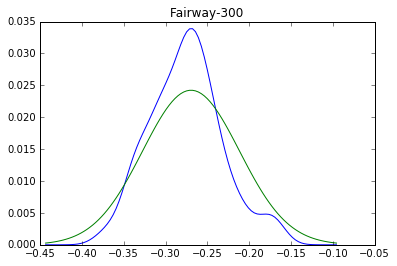

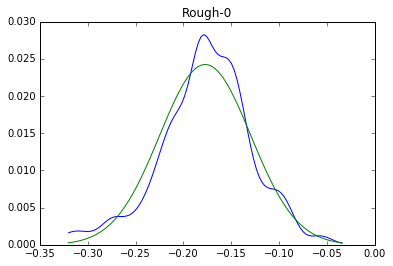

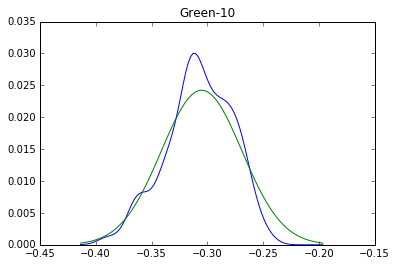

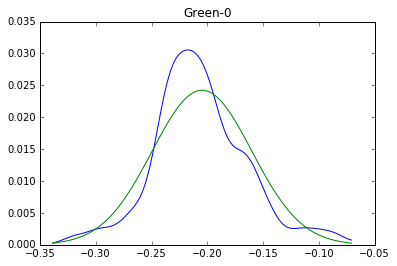

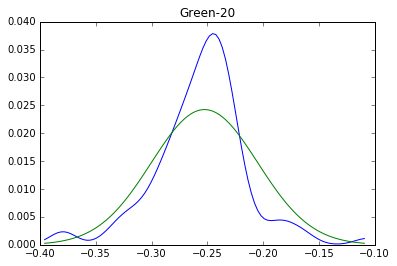

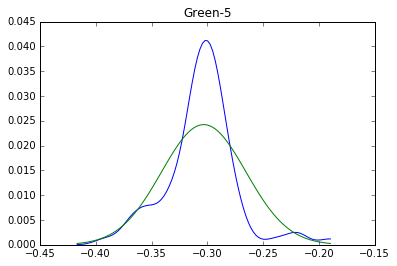

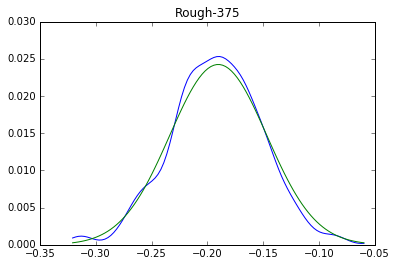

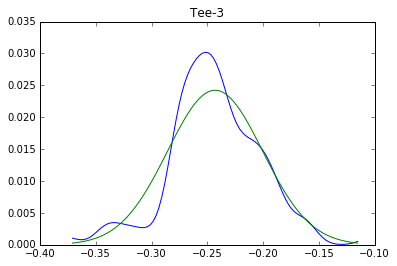

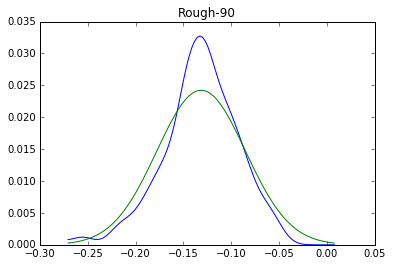

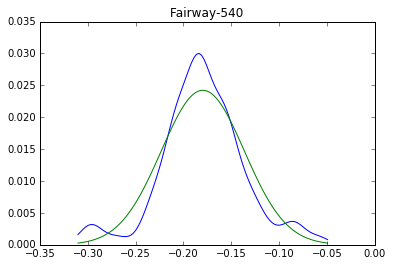

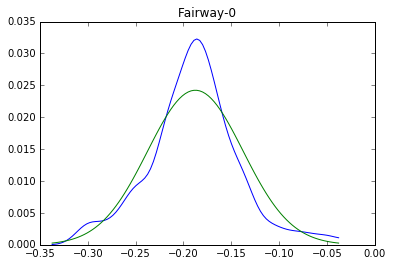

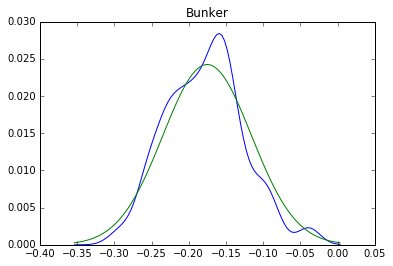

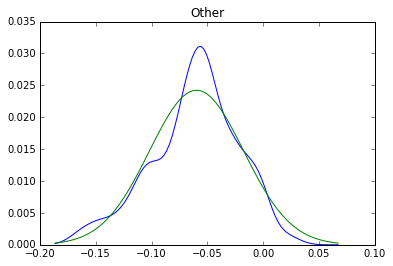

In [39]:
num_courses = len(pd.unique(data['Course_#']))
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    density = gaussian_kde(x)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(priors[cat][0],density(priors[cat][0])/density(priors[cat][0]).sum())
    plt.plot(priors[cat][0],priors[cat][1])
    plt.title(cat)
    plt.show()

Update based on data for each course, estimate posteriors

In [40]:
def update(x,p_x,r,n):
    se = 1.06/(n-3.0)**.5
    p_x *= norm.pdf(np.arctanh(x)-np.arctanh(r),0,se)
    p_x /= p_x.sum()
    return p_x

In [41]:
course_posteriors = {course:copy.deepcopy(priors) for course in pd.unique(data['Course_#'])}
for u,(year,course,round) in enumerate(round_tups):
    day = data[(data.Year==year) & (data['Course_#']==course) & (data.Round==round)]
    cat_aves = {}
    for cat,df in day.groupby('Specific_Cat'):
        player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
        cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 
                                  for player in pd.unique(day['Player_#'])])
    rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
    if len(rday)==0:
        continue
    ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
    score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
    score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan 
                          for player in pd.unique(day['Player_#'])])
    for cat in cat_aves:
        cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
        course_posteriors[course][cat][1] = update(course_posteriors[course][cat][0],
                                                 course_posteriors[course][cat][1],
                                                 spearmanr(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0],
                                                 cat_aves[cat].shape[0])    

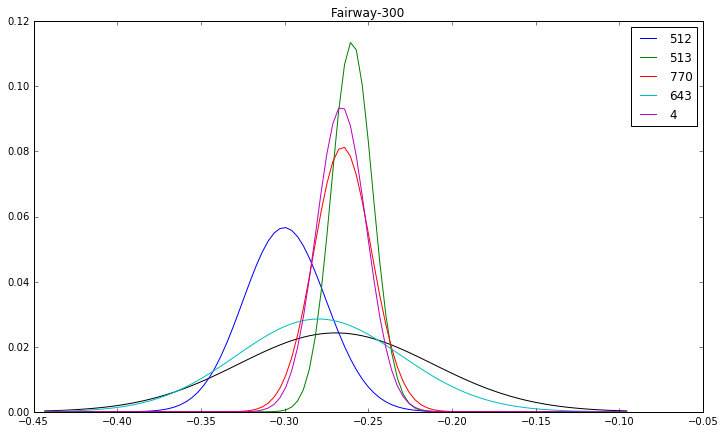

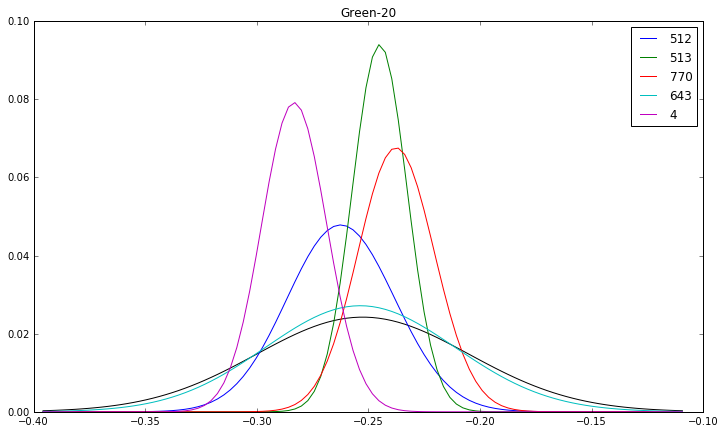

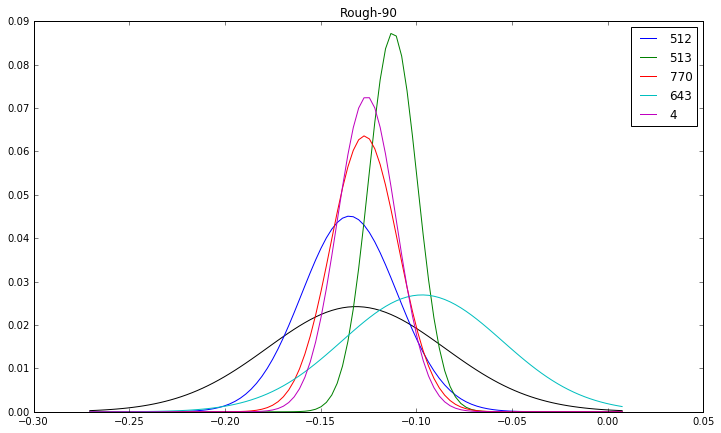

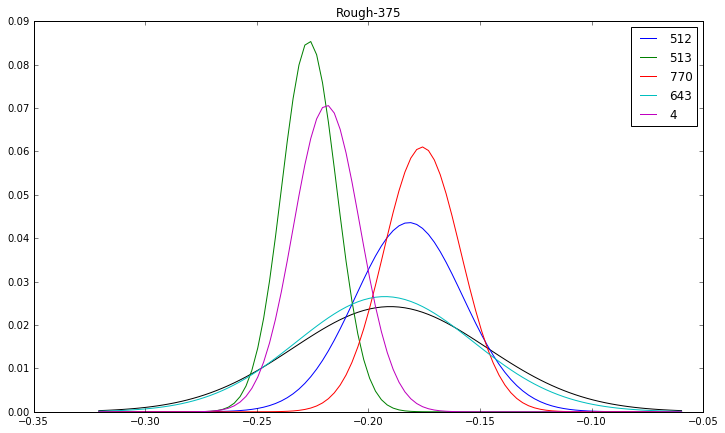

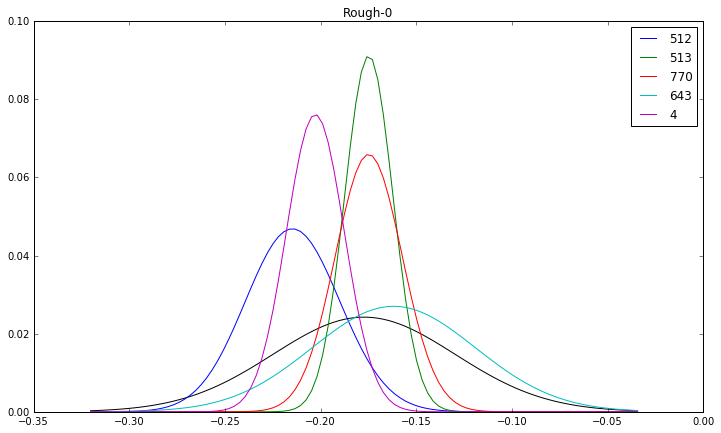

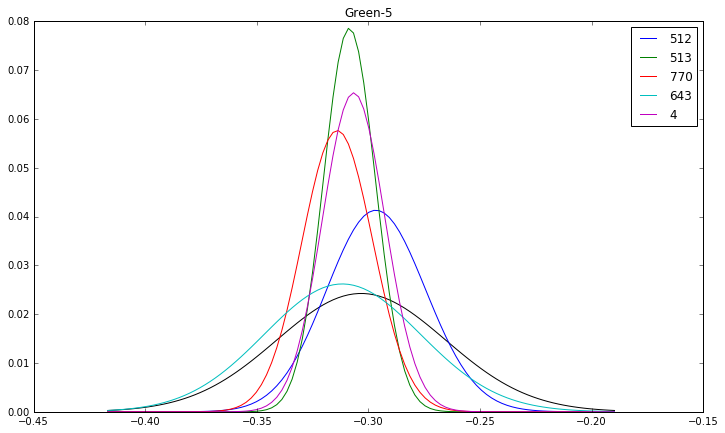

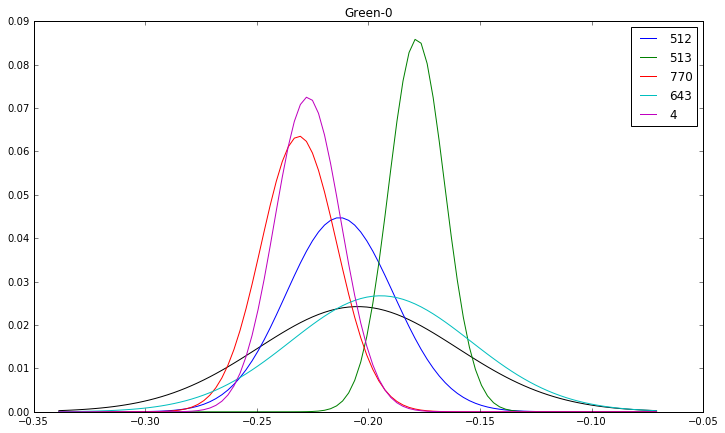

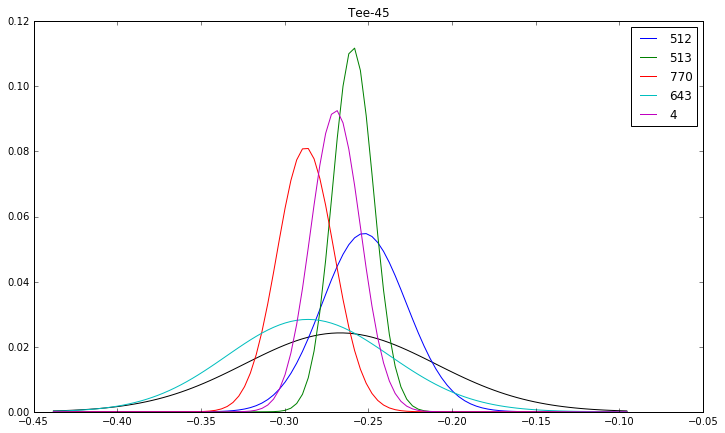

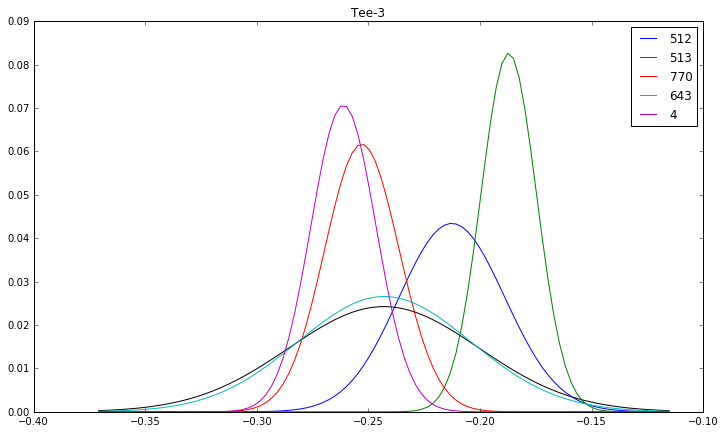

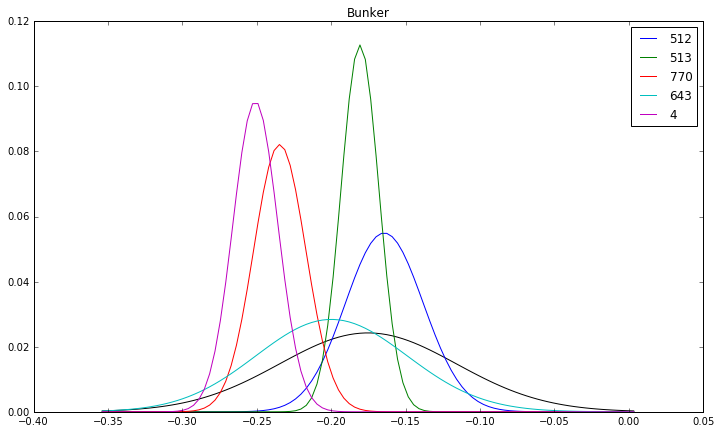

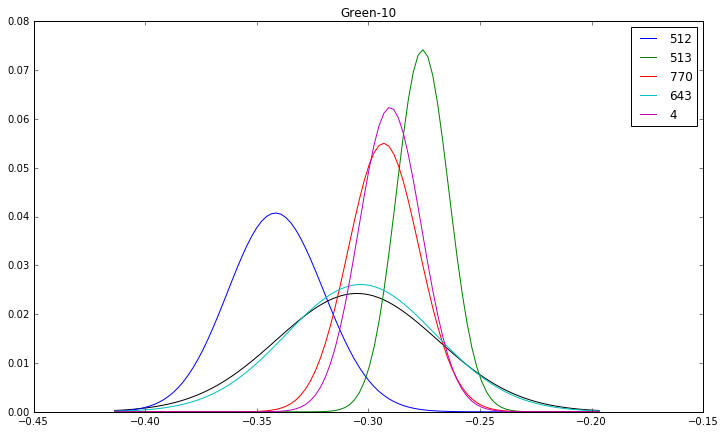

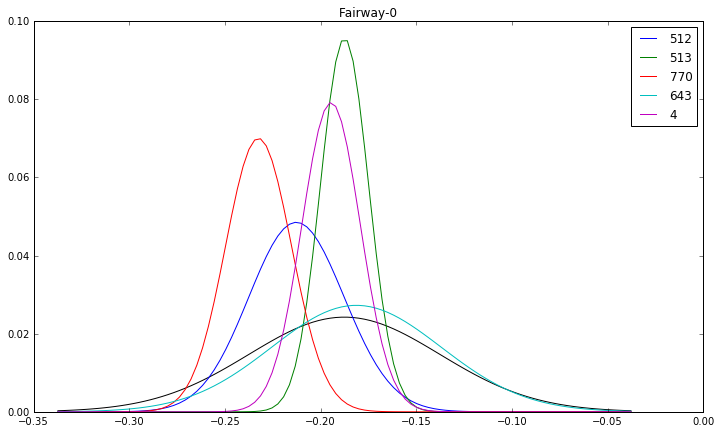

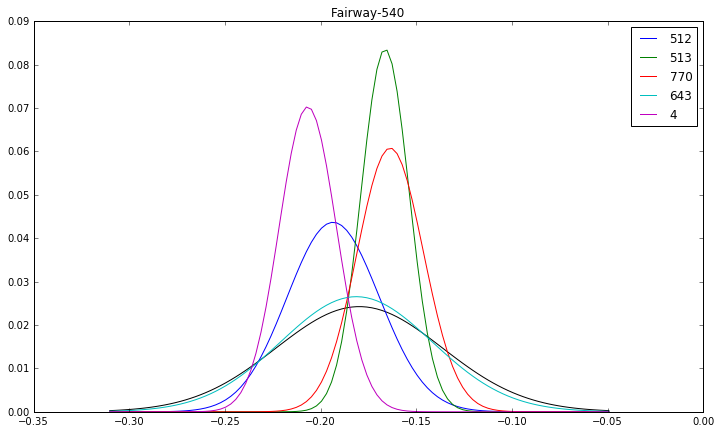

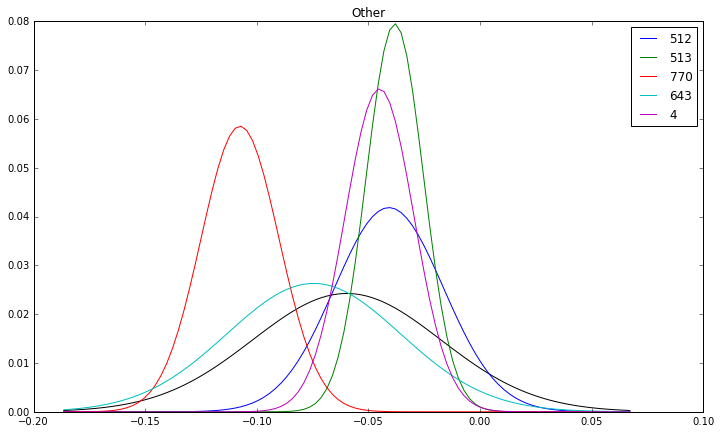

In [42]:
for cat in course_profiles[course_profiles.keys()[0]]:
    plt.figure(figsize=(12,7))
    plt.plot(priors[cat][0],priors[cat][1],c='black')
    for course in course_posteriors.keys()[:5]:
        plt.plot(course_posteriors[course][cat][0],course_posteriors[course][cat][1],label=str(course));
    plt.title(cat)
    plt.legend()
    plt.show();

Overall importances

In [53]:
overall_importances = defaultdict(list)
big_score_vec = []
cats = pd.unique(data.Specific_Cat)
for u,(year,course,round) in enumerate(round_tups):
    day = data[(data.Year==year) & (data['Course_#']==course) & (data.Round==round)]
    rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
    if len(rday)==0 or len(day)==0:
        continue
    players = pd.unique(day['Player_#'])
    cat_aves = {}
    for cat in cats:
        df = day[day.Specific_Cat==cat]
        if len(df)==0:
            cat_aves[cat] = [0.0]*len(players)
        player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
        cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 for player in players])
    ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
    score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
    score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan for player in players])
    big_score_vec.extend(score_vec[~np.isnan(score_vec)].tolist())
    for cat in cat_aves:
        overall_importances[cat].extend(cat_aves[cat][~np.isnan(score_vec)].tolist())

In [54]:
len(big_score_vec)

206663

In [55]:
len(overall_importances['Tee-3'])

206663

In [58]:
corrs = {cat:spearmanr(big_score_vec,overall_importances[cat])[0] for cat in cats}
for cat in sorted(corrs,key=corrs.get):
    print cat, corrs[cat]

Green-5 -0.304941271696
Green-10 -0.298649666054
Fairway-300 -0.272263909919
Green-20 -0.248707559898
Tee-3 -0.242233250554
Tee-45 -0.238152965774
Green-0 -0.215276999646
Fairway-0 -0.191032134942
Rough-375 -0.190076986988
Bunker -0.185177097341
Fairway-540 -0.174208935297
Rough-0 -0.173185897508
Rough-90 -0.127498349948
Other -0.0644638738032


In [60]:
corrs = {cat:np.corrcoef(big_score_vec,overall_importances[cat])[0,1] for cat in cats}
for cat in sorted(corrs,key=corrs.get):
    print cat, corrs[cat]

Green-5 -0.293980727425
Green-10 -0.293672183614
Fairway-300 -0.271030501048
Tee-3 -0.252776058587
Green-20 -0.25262506432
Tee-45 -0.252187271566
Green-0 -0.23141893491
Rough-375 -0.186604019539
Fairway-0 -0.185818557228
Bunker -0.185545167469
Rough-0 -0.172183579793
Fairway-540 -0.171808412762
Rough-90 -0.134587014854
Other -0.0719783974641


In [61]:
len(round_tups)

2178

In [67]:
len(pd.DataFrame(round_tups).drop_duplicates([0,1])[[0,1]])

547

In [72]:
len(pd.DataFrame(tournorder)[[0,1]].drop_duplicates())

546